In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import deque
import numpy as np, scipy.stats as st

In [10]:
def create_graph(nodes, edges):
    """
    Create a directed graph. Each node represents a city. Each directed edge
    represents a road from one city to another. 
    Draw the graph with label and return the graph object.
    """
    G = nx.DiGraph()

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    nx.draw_networkx(G)
    plt.axis("off")
    plt.show()
    return G

def initialize(G, daily_capacity):
    """
    Initilize the properties of the graph. 
    
    Input:
    G: a directed graph object. 
    daily_capacity (int): The total number of parcels per day allow on each road. 
    
    Each node has 2 properties:
    orders: a priority queue storing the orders beginning from that city. 
    cost : the cost incurred by storing parcels overnight. 
    """
    for city in G.nodes:
        G.nodes[city]["orders"] = deque([])
        G.nodes[city]["cost"] = 0
    for edge in G.edges:
        G.edges[edge]["daily_capacity"] = daily_capacity
        
def new_order(G, max_order = 300):
    """
    Generate new orders by iterating through each city. For each city, choose a random destination
    in the graph and generate a random number of parcels for that order.  
    
    Input:
    G: a directed graph object.
    max_order (int): The maximum number of parcels to be transported. (Default = 300)
    """
    for city in G.nodes:
        city_list = list(G.nodes)
        city_list.remove(city)
        destination = random.choice(city_list)
        value = random.randint(0,max_order)
        G.nodes[city]["orders"].appendleft([destination, value])

def reset_capacity(G, max_capacity):
    """
    Reset the capacity for all the edge to its original value.
    
    Input:
    G: a directed graph object.
    max_capacity (dict): contains the original "daily_capacity" attributes of all the edges in G. 
    
    """
    for edge, value in max_capacity.items():
        G[edge[0]][edge[1]]["daily_capacity"] = value 
        
def update(G):
    """
    Update node's "orders" and "cost" after one day. Deliver the parcels to new destinations.
    Keep track of edges' "daily_capacity", and the number of parcels delivered.
    """
    daily_delivered = 0 #number of parcels delivered that day
    for node in G.nodes:
        orders = G.nodes[node]["orders"]  
        remaining_orders = deque([]) #a queue storing the untransported orders. 
        
        for _ in range(len(orders)):
            order = orders.pop() 
            destination = order[0] #final destination of the order
            shortest_path = nx.shortest_path(G, source = node, target = destination)
            i, j  = shortest_path[0], shortest_path[1]
            capacity = G[i][j]["daily_capacity"] 
            
            if order[1] <= capacity:
                capacity -= order[1]
                transported = order[1]
            else: 
                capacity = 0 
                order[1] -= capacity 
                transported = capacity 
                remaining_orders.append([destination, order[1]]) #untransported parcels of this order
            
            G[i][j]["daily_capacity"] = capacity #update the remaining capacity for that day

            #move the parcels to the next node on the path 
            if j != destination:
                G.nodes[j]["orders"].appendleft([destination, transported])
            else: #if the parcels reach their destination
                daily_delivered += transported 
   
        #update untransported orders and storage cost
        G.nodes[node]["orders"] = remaining_orders
        if len(remaining_orders) != 0:
            for remaining_order in G.nodes[node]["orders"]:
                G.nodes[node]["cost"] += remaining_order[1]
    return daily_delivered

def simulation(G, num_sim = 1000, days = 30, daily_capacity = 300):
    """
    Simulate the delivering process on the same graph. Calculate 
    the storage cost incurred and visualize it. 
    
    Input:
    G: a directed graph object
    num_sim (int): number of simulations (Default = 1000)
    days (int): number of days for each simulation (Default = 30)
    daily_capacity (int): the maximum capacity per road (Default = 300)
    """
    cities_cost = {} #dictionary of cost per simulation in each city
    for city in G.nodes:
        cities_cost[city] = [] 
        
    total_cost = [] #list of total cost per simulation 
    total_delivered = [] #list of total number of delivered parcels per simulation 
    
    #main program
    for sim in range(num_sim):
        delivered = 0 #number of parcels delivered 
        cost = 0 #total cost

        days = days
        initialize(G, daily_capacity)
        max_capacity = nx.get_edge_attributes(G, "daily_capacity") 
        
        #simulate
        for day in range(days):
            reset_capacity(G, max_capacity)
            new_order(G)
            delivered += update(G)
        
        #append the cost, delivered parcels after the simulation by each city and the total for all cities
        for city in G.nodes:
            cities_cost[city].append(G.nodes[city]["cost"])
            cost += G.nodes[city]["cost"]
            
        total_cost.append(cost)
        total_delivered.append(delivered)
    
    #Visualize results 
    for city in G.nodes:
        print("The average cost for city {} is {}".format(city, np.mean(cities_cost[city])))
        
    plt.hist(total_cost)
    plt.title("The total cost after 30 days")
    plt.show()
    print("The average total cost in {} simulations is {}".format(num_sim,np.mean(total_cost)))
    print("The confidence interval is {}".format(st.t.interval(0.95, len(total_cost)-1, loc=np.mean(total_cost), scale=st.sem(total_cost))))
    print("The average number of parcels delivered is {}".format(np.mean(total_delivered)))

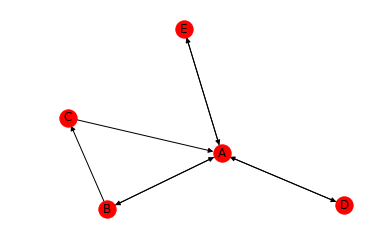

The average cost for city A is 33448.691
The average cost for city B is 1013.512
The average cost for city C is 0.0
The average cost for city D is 0.0
The average cost for city E is 0.0


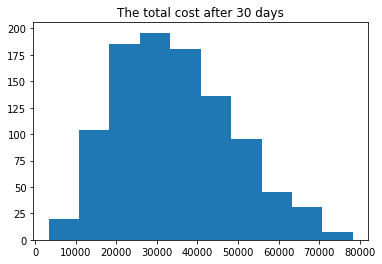

The average total cost in 1000 simulation is 34462.203
The confidence interval is (33579.459908984281, 35344.946091015721)
The average number of parcels delivered is 20054.019


In [3]:
nodes = ["A", "B", "C", "D", "E"]
edges = [("A", "B"), ("B","A"), ("B", "C"),
        ("A", "D"), ("D", "A"), ("E","A"), ("C","A"), ("A","E")]
G = create_graph(nodes, edges)
simulation(G)

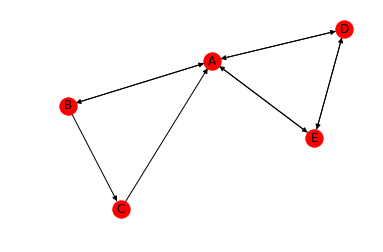

The average cost for city A is 28336.33
The average cost for city B is 951.987
The average cost for city C is 0.0
The average cost for city D is 0.0
The average cost for city E is 0.0


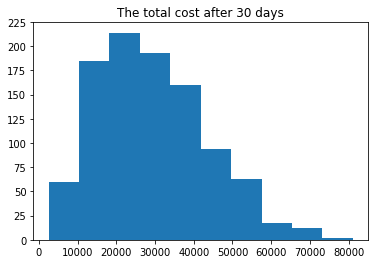

The average total cost in 1000 simulation is 29288.317
The confidence interval is (28420.888335491763, 30155.745664508235)
The average number of parcels delivered is 20363.754


In [4]:
#Add edges to reduce loads for node A
G.add_edges_from([("D", "E"),("E", "D")])
nx.draw_networkx(G)
plt.axis("off")
plt.show()

simulation(G)

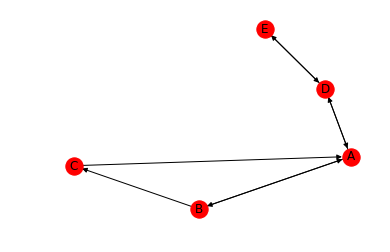

The average cost for city A is 31866.709
The average cost for city B is 1009.213
The average cost for city C is 0.0
The average cost for city D is 14147.344
The average cost for city E is 0.0


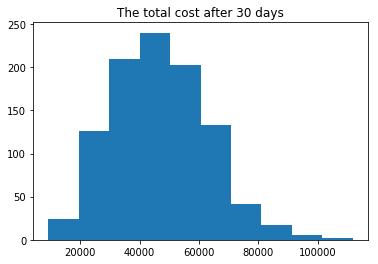

The average total cost in 1000 simulation is 47023.266
The confidence interval is (46039.584396651371, 48006.947603348635)
The average number of parcels delivered is 19280.137


In [5]:
#In case of emergency a road is blocked
G.remove_edges_from([("A", "E"),("E", "A")])
nx.draw_networkx(G)
plt.axis('off')
plt.show()
simulation(G)

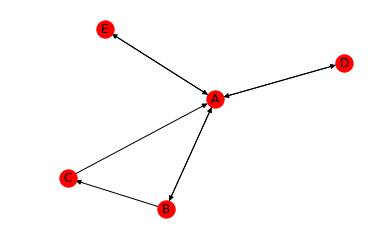

The average cost for city A is 33180.1512
The average cost for city B is 987.1524
The average cost for city C is 0.0
The average cost for city D is 0.0
The average cost for city E is 0.0


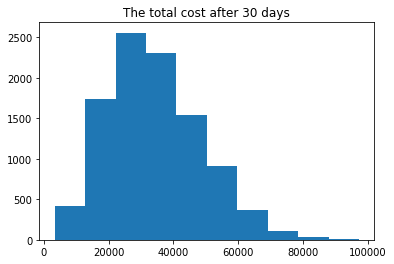

The average total cost in 10000 simulations is 34167.3036
The confidence interval is (33884.904534526424, 34449.702665473575)
The average number of parcels delivered is 20090.055


In [11]:
#run the simulation 10000 times
nodes = ["A", "B", "C", "D", "E"]
edges = [("A", "B"), ("B","A"), ("B", "C"),
        ("A", "D"), ("D", "A"), ("E","A"), ("C","A"), ("A","E")]
G = create_graph(nodes, edges)
simulation(G, num_sim = 10000)

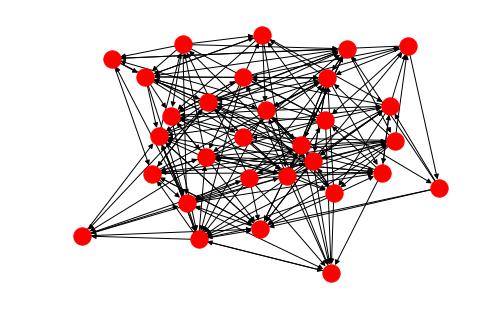

In [6]:
#simulate on a small world graph with much bigger size 
small_world_graph = nx.erdos_renyi_graph(30, 0.2, seed = 123,directed = True)
nx.draw(small_world_graph)
plt.show()

The average cost for city 0 is 4904.178
The average cost for city 1 is 3958.981
The average cost for city 2 is 6303.041
The average cost for city 3 is 2988.868
The average cost for city 4 is 2445.275
The average cost for city 5 is 1104.04
The average cost for city 6 is 674.666
The average cost for city 7 is 2321.303
The average cost for city 8 is 778.749
The average cost for city 9 is 1268.558
The average cost for city 10 is 649.025
The average cost for city 11 is 1493.369
The average cost for city 12 is 767.401
The average cost for city 13 is 1158.866
The average cost for city 14 is 3534.212
The average cost for city 15 is 171.809
The average cost for city 16 is 435.779
The average cost for city 17 is 123.694
The average cost for city 18 is 866.077
The average cost for city 19 is 693.344
The average cost for city 20 is 357.405
The average cost for city 21 is 233.558
The average cost for city 22 is 656.964
The average cost for city 23 is 403.811
The average cost for city 24 is 233.542


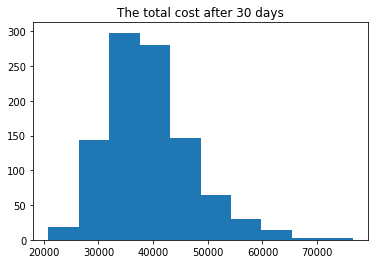

The average total cost in 1000 simulation is 39276.049
The confidence interval is (38788.502319456413, 39763.595680543585)
The average number of parcels delivered is 130916.93


In [7]:
simulation(small_world_graph)

The average cost for city 0 is 173.571
The average cost for city 1 is 163.935
The average cost for city 2 is 202.287
The average cost for city 3 is 100.826
The average cost for city 4 is 61.091
The average cost for city 5 is 14.845
The average cost for city 6 is 17.49
The average cost for city 7 is 57.788
The average cost for city 8 is 16.037
The average cost for city 9 is 29.934
The average cost for city 10 is 10.624
The average cost for city 11 is 38.043
The average cost for city 12 is 11.625
The average cost for city 13 is 29.973
The average cost for city 14 is 145.981
The average cost for city 15 is 1.31
The average cost for city 16 is 8.567
The average cost for city 17 is 0.747
The average cost for city 18 is 7.521
The average cost for city 19 is 5.313
The average cost for city 20 is 5.094
The average cost for city 21 is 2.896
The average cost for city 22 is 14.239
The average cost for city 23 is 5.433
The average cost for city 24 is 2.315
The average cost for city 25 is 4.786
The

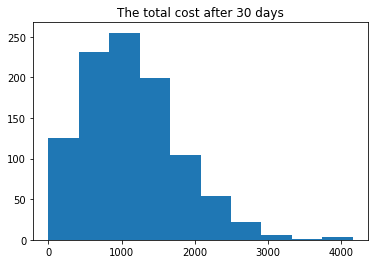

The average total cost in 1000 simulation is 1134.263
The confidence interval is (1094.154101279833, 1174.3718987201669)
The average number of parcels delivered is 132306.29


In [8]:
simulation(small_world_graph, daily_capacity= 600)